In [1]:
import numpy as np
import pandas as pd

from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor

from envs.bess_env import BatteryEnv
from utils.csv_handler import load_price_data
from utils.plot_handler import plot_bess_rollout
from utils.eval_handler import evaluate_financials, evaluate_rollout

In [2]:
# === Load training data: full November 2024 ===
df_train, price_train, timestamps_train = load_price_data(
    csv_path="../data/raw/dayahead_2024_11.csv",
    resolution="15min",
    time_range=("2024-11-01", "2024-11-07"),
)

# === Load evaluation data: first week of November 2025 ===
df_eval, price_eval, timestamps_eval = load_price_data(
    csv_path="../data/raw/dayahead_2025_11.csv",
    resolution="15min",
    time_range=("2025-11-01", "2025-11-07"),
)

print(len(price_eval), "time steps in a week (should be 672)")
print("Week from", timestamps_eval[0], "to", timestamps_eval[-1])

672 time steps in a week (should be 672)
Week from 2025-11-01 00:00:00+01:00 to 2025-11-07 23:45:00+01:00


In [3]:
# ------------------------------------------------
# Training environment: uses full November 2024 as pool,
# each episode ~ one week starting at a random index.
# ------------------------------------------------
train_env_raw = BatteryEnv(
    price_series=price_train,
    demand_series=None,
    timestamps=timestamps_train,
    dt_hours=0.25,              # 15 min
    capacity_kWh=50.0,
    p_max_kW=10.0,
    use_discrete_actions=True,  # required for DQN
    use_price_forecast=True,
    forecast_horizon_hours=3.0,
    episode_days=7.0,            # one-week logical episode
    random_start=True,  
    random_seed=42,
)

# Wrap with Monitor for SB3 (logs episode stats)
train_env = Monitor(train_env_raw)

dqn_model = DQN(
    "MlpPolicy",
    train_env,
    learning_rate=1e-3,
    buffer_size=50_000,
    learning_starts=1_000,
    batch_size=64,
    gamma=0.99,
    tau=1.0,
    train_freq=4,
    target_update_interval=1_000,
    exploration_initial_eps=1.0,
    exploration_final_eps=0.05,
    exploration_fraction=0.3,
    verbose=1,
)

dqn_model.learn(
    total_timesteps=20_000,
    log_interval=10,
    progress_bar=True,
)

print("DQN training completed.")
print(train_env.observation_space.shape)

  99% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 19,889/20,000  [ 0:00:23 < 0:00:01 , 825 it/s ]

DQN training completed.
(21,)


Episode finished early at step 671
=== Financial Summary ===
Total revenue    (EUR): 6.667
Degradation cost (EUR): 0.647
Penalty cost     (EUR): 0.000
Net profit       (EUR): 6.019


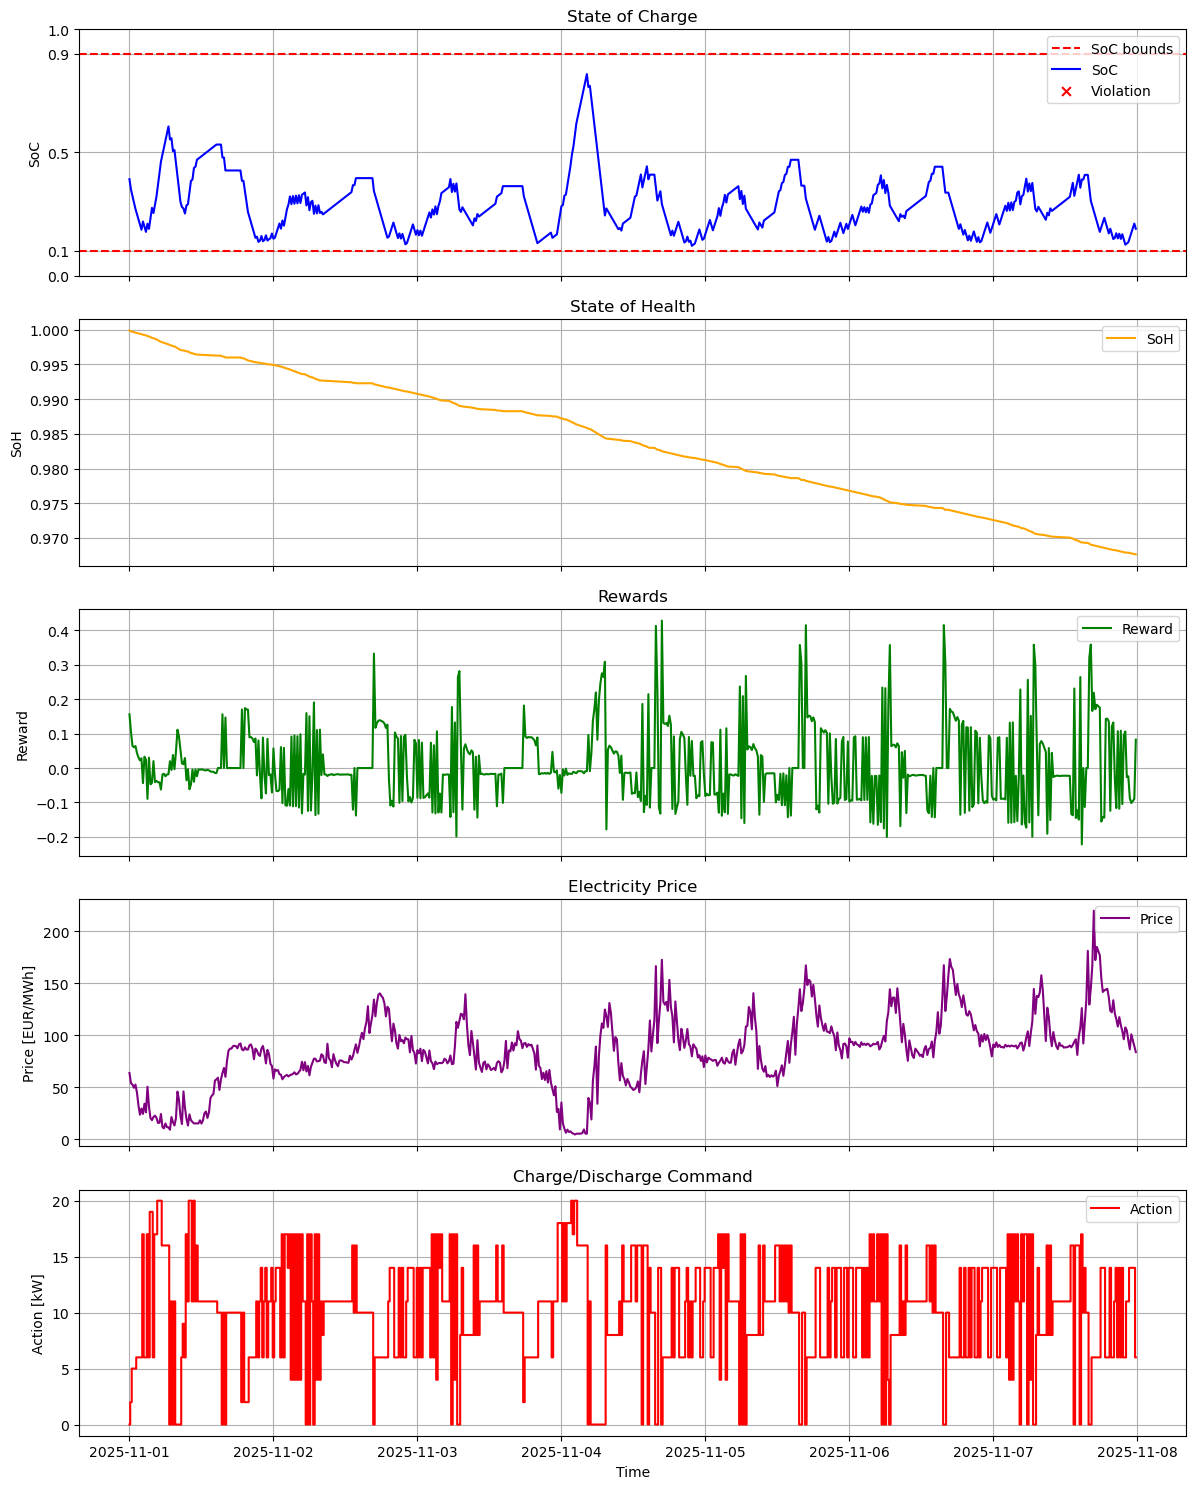

In [4]:
# Use a "fresh" env for evaluation (same config, different seed)
eval_env = BatteryEnv(
    price_series=price_eval,
    demand_series=None,
    timestamps=timestamps_eval,
    dt_hours=0.25,
    capacity_kWh=50.0,
    p_max_kW=10.0,
    use_discrete_actions=True,
    use_price_forecast=True,
    forecast_horizon_hours=3.0,
    episode_days=7.0,             # matches the eval week length
    random_start=False, 
    random_seed=123, 
)

results = evaluate_rollout(
    model=dqn_model,
    env=eval_env,
)

evaluate_financials(
    revenue_list=results["revenue"],
    deg_cost_list=results["deg_cost"],
    penalty_list=results["penalty"],
)

plot_bess_rollout(
    soc_list=results["soc"],
    soh_list=results["soh"],
    reward_list=results["reward"],
    price_list=results["price_true"],
    action_list=results["action"],
    violated_list=results["violated"], 
    timestamps=timestamps_eval,
)